In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn import linear_model, metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

### 1. Gather Data

#### 1.1. Loading the downloaded quotes file of Nongshim.
___

In [2]:
quotes = pd.read_csv('../data/nongshim_historical_weekly_quotes.csv')
quotes = quotes.rename(columns={'Date': 'week', 'Close': 'close_price',
                                'Volume': 'volume'})
quotes = quotes[['week', 'close_price', 'volume']]

#### 1.2. Loading file downloaded from Google Trends website
___

In [3]:
trends = pd.read_csv('../data/bts_google_trends.csv', skiprows=1, sep=",")
trends = trends.rename(columns={'Week': 'week', 'BTS: (Worldwide)': 'search_interest'})

### 2. Transform and Clean

#### 2.1. Check if there is any missing data.
___

In [4]:
quotes.isnull().sum()

week           0
close_price    0
volume         0
dtype: int64

In [5]:
trends.isnull().sum()

week               0
search_interest    0
dtype: int64

#### 2.2. Changing datatype of dates from object to datetime
___

In [6]:
quotes['week'] = quotes['week'].astype('datetime64[ns]')
trends['week'] = trends['week'].astype('datetime64[ns]')

### 3. Explore

#### 3.1. Let's plot the close price, volume and search interest seaprately to see how they changed over time.
___

In [7]:
sns.set_style('darkgrid')

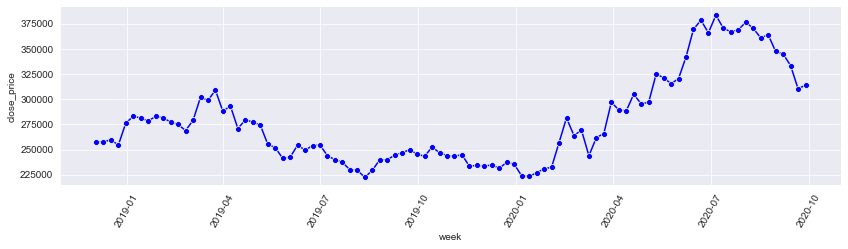

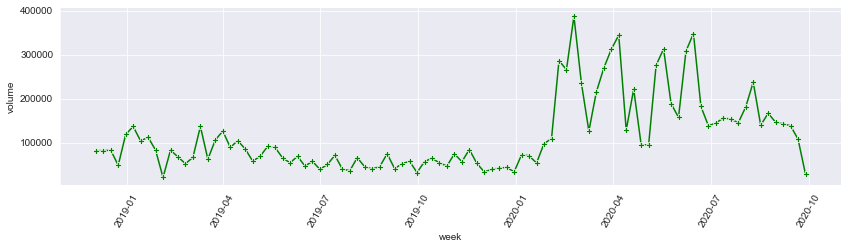

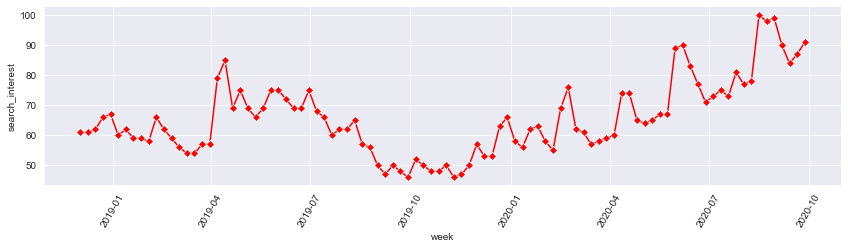

In [8]:
g1 = sns.relplot(x ='week', y='close_price', data=quotes, kind='line', color="blue", 
                 marker="o", height=3, aspect=11.7/3)
g1.set_xticklabels(rotation=60)
g2 = sns.relplot(x ='week', y='volume', data=quotes, kind='line', color="green", marker="P",
                 height=3, aspect=11.7/3)
g2.set_xticklabels(rotation=60)
g3 = sns.relplot(x ='week', y='search_interest', data=trends, kind='line', color="red", 
                 marker="D", height=3, aspect=11.7/3)
g3.set_xticklabels(rotation=60)
plt.show()

#### 3.2. Let's scale the values (*close price of Nongshim and search interest of BTS*) and plot them to see if they look correlated
___

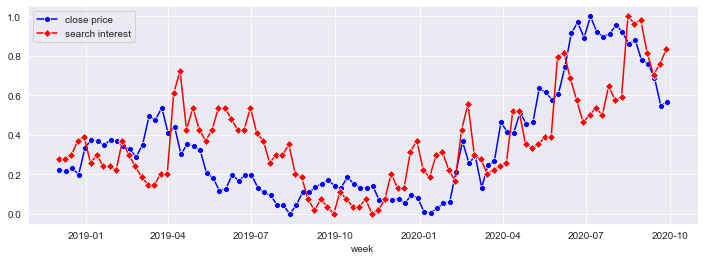

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(x=quotes.week, y=minmax_scale(quotes.close_price), marker="o", 
             label='close price', color='blue')
sns.lineplot(x=trends.week, y=minmax_scale(trends.search_interest), marker="D", 
             label="search interest", color='red')

plt.legend(loc='best')
plt.show()

#### 3.3. Let's plot some SMAs (Simple Moving Averages)
___

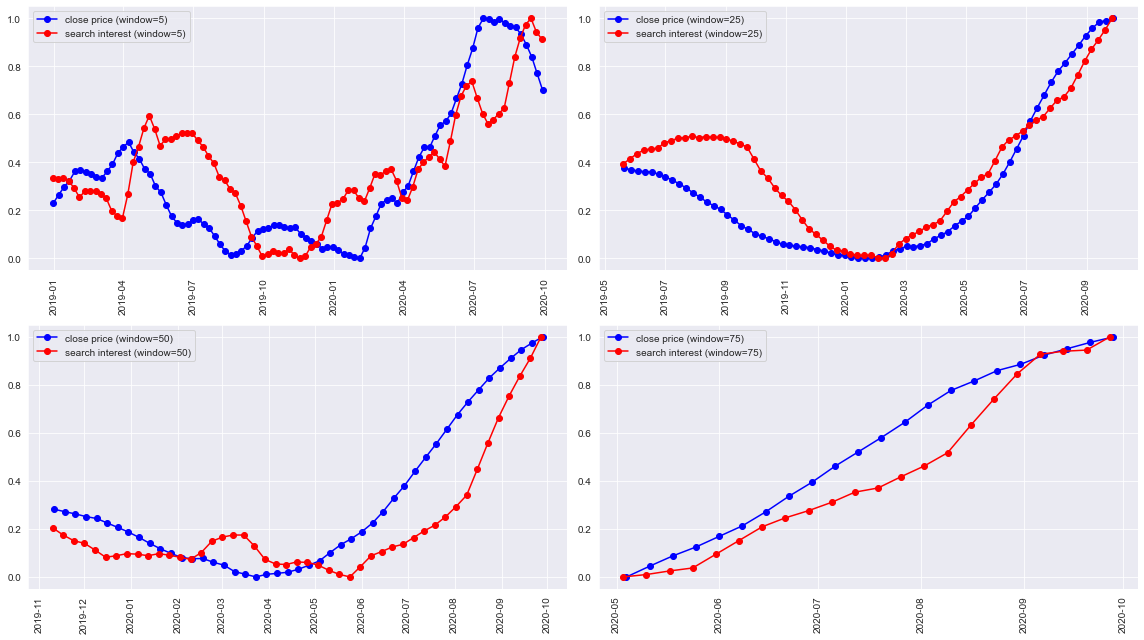

In [10]:
plt.figure(figsize=(16,9))
plt.subplot(221)
plt.plot(quotes.week, minmax_scale(quotes.close_price.rolling(window=5).mean()),
         "bo-",
         label='close price (window=5)')
plt.plot(trends.week, minmax_scale(trends.search_interest.rolling(window=5).mean()),
         "ro-",
         label="search interest (window=5)")
plt.xticks(rotation='vertical')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(quotes.week, minmax_scale(quotes.close_price.rolling(window=25).mean()),
         "bo-",
         label='close price (window=25)')
plt.plot(trends.week, minmax_scale(trends.search_interest.rolling(window=25).mean()),
         "ro-",
         label="search interest (window=25)")
plt.xticks(rotation='vertical')
plt.legend(loc='best')
plt.subplot(223)
plt.plot(quotes.week, minmax_scale(quotes.close_price.rolling(window=50).mean()),
         "bo-",
         label='close price (window=50)')
plt.plot(trends.week, minmax_scale(trends.search_interest.rolling(window=50).mean()),
         "ro-",
         label="search interest (window=50)")
plt.xticks(rotation='vertical')
plt.legend(loc='best')
plt.subplot(224)
plt.plot(quotes.week, minmax_scale(quotes.close_price.rolling(window=75).mean()),
         "bo-",
         label='close price (window=75)')
plt.plot(trends.week, minmax_scale(trends.search_interest.rolling(window=75).mean()),
         "ro-",
         label="search interest (window=75)")
plt.xticks(rotation='vertical')
plt.legend(loc='best')
plt.tight_layout() 

### 4. Build Model

#### 4.1. The data does look slightly correlated. Let's do a hypothesis test on Pearson correlation
___

##### Null Hypothesis: The close price is independent of the search interest and the two are completely uncorrelated.

In [11]:
def pearson_r(x, y):
    """
    Compute Pearson correlation coefficient between two arrays.
    
    """
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0, 1]

- __X__(independent variable/predictor) = search interest
- __y__(dependent variable/outcome)     = close price

In [12]:
X = trends.set_index('week')
y = quotes.set_index('week')[['close_price']]
y.index = y.index - datetime.timedelta(days=1)

##### 4.1.1. Compute observed correlation

In [13]:
r_observed = pearson_r(X.search_interest, y.close_price)

##### 4.1.2. Initialize permutation replicates: perm_replicates

In [14]:
perm_replicates = np.empty(10000)

##### 4.1.3. Draw replicates

In [15]:
for i in range(10000):
    search_interest_permuted = np.random.permutation(X.search_interest)
    perm_replicates[i] = pearson_r(search_interest_permuted, y.close_price)

##### 4.1.4. Plot the figure.
##### The red line indicates the observed value and the histogram is the distribution of permuted values

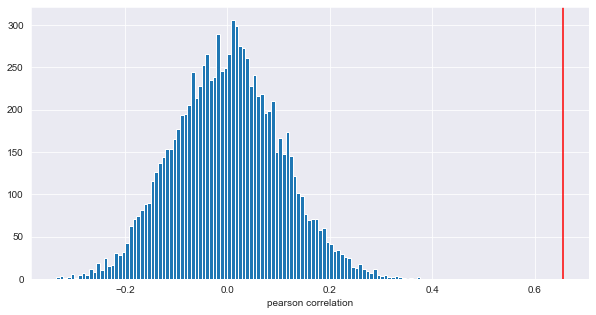

In [16]:
plt.figure(figsize=(10,5))

_ = plt.hist(perm_replicates, bins=100)
_ = plt.axvline(x=r_observed, color='r', linestyle='-')
_ = plt.xlabel("pearson correlation")

##### 4.1.5. Compute p-value

In [17]:
p = np.sum(perm_replicates >= r_observed) / len(perm_replicates)
print('p-value =', p)

p-value = 0.0


##### Since the p-value <= 0, so we can reject the null hypothesis, and we cannot say that the correlation observed between close_price of Nongshim and search interest in BTS was just random chance.

#### 4.2. Let's build a linear model. Divide the datasets into train and test.
___

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#### 4.3. Checking if data is skewed
___

In [19]:
print("TRAINING SET\n")

print("1. MEAN")
print("x (search_interest) :: ", np.mean(X_train)[0])
print("y (close price)     :: ", np.mean(y_train)[0])
print("\n")
print("2. MEDIAN")
print("x (search_interest) :: ", np.median(X_train))
print("y (close price)     :: ", np.median(y_train))

TRAINING SET

1. MEAN
x (search_interest) ::  65.01492537313433
y (close price)     ::  279888.05970149254


2. MEDIAN
x (search_interest) ::  63.0
y (close price)     ::  275000.0


##### Mean and Median are similar so the training set isn't skewed by any outliers

#### 4.4. Let's make a regression plot using training data
___

In [20]:
train_df = X_train.merge(y_train, on='week')

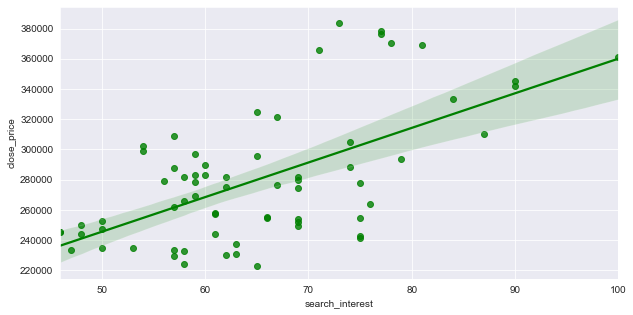

In [21]:
_ = plt.figure(figsize=(10,5))
_ = sns.regplot(data=train_df, x='search_interest', y='close_price',
               color='green')

#### 4.5. Let's try bootstrapping
___

In [22]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

##### 4.5.1. Generate replicates of slope and intercept using pairs bootstrap

In [23]:
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(
    train_df['search_interest'], train_df['close_price'], size=1000)

##### 4.5.2. Generate array of x-values for bootstrap lines

In [24]:
x = np.array([40, 100])

##### 4.5.3. Plot the bootstrap lines

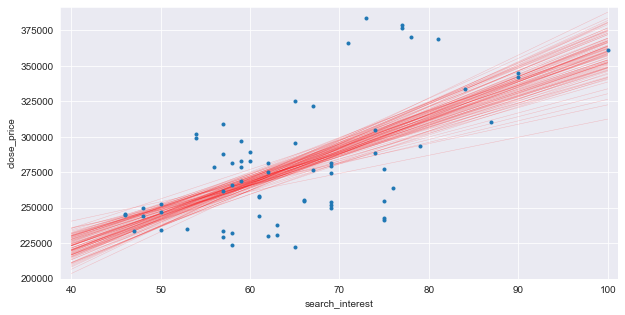

In [25]:
plt.figure(figsize=(10,5))
for i in range(100):
    plt.plot(x, 
             bs_slope_reps[i] * x + bs_intercept_reps[i],
             linewidth=0.5, alpha=0.2, color='red')

plt.plot(train_df['search_interest'], train_df['close_price'], marker='.', linestyle='none')

plt.xlabel('search_interest')
plt.ylabel('close_price')
plt.margins(0.02)
plt.show()

#### 4.6. Setting up the linear regression model using the training dataset
___

In [26]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)

print("Correlation      ::", np.sqrt(lm.score(X_train, y_train)), "\n")
print("Coefficient of x ::", lm.coef_[0][0], "\n")
print("Intercept        ::", lm.intercept_[0])

Correlation      :: 0.611392586428232 

Coefficient of x :: 2292.053261501519 

Intercept        :: 130870.38795372212


##### From the correlation value we can say that it is moderate correlation and not a strong correlation.

### 5. Communicating Results

#### 5.1. Predicting the close prices in test dataset using the model fitted above
___
- Predicting close prices using the linear regression model
- Plotting actual close prices against the ones predicted

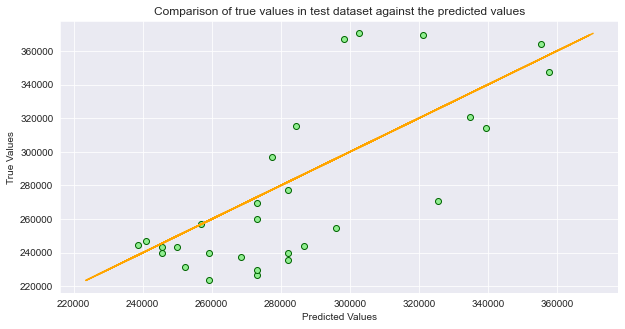

In [27]:
y_predicted = lm.predict(X_test)

plt.figure(figsize=(10,5))
plt.title('Comparison of true values in test dataset against the predicted values')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.scatter(y_predicted, y_test,  color='lightgreen', edgecolor="darkgreen")
plt.plot(y_test, y_test, color = "orange")
plt.show()

##### Very few points are close to the line and some seem to be way off.

#### 5.2. Let's look at some metrics to see how well the model predicted
___

In [28]:
print("Coefficient of determination (R^2) ::", 
      metrics.r2_score(y_test, y_predicted), "\n")
print("Root Mean Squared Error (RMSE)     ::", 
      np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))

Coefficient of determination (R^2) :: 0.5211886688876841 

Root Mean Squared Error (RMSE)     :: 33172.21904840343


##### The coefficient of determination is telling us that there is variability in the outcome that cannot be explained by the model.